In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import os
from brainspace.gradient import GradientMaps
import glob

In [2]:
micapipe_dir = '/data/mica4/BIDS_MICs_sunset/derivatives/micapipe' #NOTE rsfMRI data seems to be missing!
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
gradient_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/Gradients/'
tmp_dir = 'tmp_MICs-FC'

subs = glob.glob(hippunfold_dir + '/sub-HC*')
for i in range(len(subs)): subs[i] = subs[i].split('/')[-1]
ses = 'ses-01'
hemi = ['L','R']
label = ['hipp','dentate'] 

In [28]:
# warp surfaces to func space then sample
sigma = 2 #Gaussian smoothing kernal sigma (mm)
shp = [419,64]
!mkdir -p {tmp_dir}

for sub in subs:
    # convert affines
    cmd1a = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/{sub}/{ses}/xfm/{sub}_{ses}_rsfmri_from-rsfmri_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
        f'-o {tmp_dir}/{sub}_{ses}_tmp0GenericAffine0.txt'
    !{cmd1a}
    cmd1b = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/{sub}/{ses}/xfm/{sub}_{ses}_rsfmri_from-nativepro_rsfmri_to-rsfmri_mode-image_desc-SyN_0GenericAffine.mat '\
        f' -inv '\
        f'-o {tmp_dir}/{sub}_{ses}_tmp0GenericAffine1.txt'
    !{cmd1b}

    for h in range(len(hemi)):
        for l in range(len(label)):
            image = nib.gifti.GiftiImage()
            out_array = []
            
            # apply warp
            cmd3 = f'wb_command -surface-apply-warpfield '\
                f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                f'{micapipe_dir}/{sub}/{ses}/xfm/{sub}_{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_deform.surf.gii'
            !{cmd3}

            #apply affines
            cmd2a = f'wb_command -surface-apply-affine '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_deform.surf.gii '\
                f'{tmp_dir}/{sub}_{ses}_tmp0GenericAffine0.txt '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_aff0.surf.gii'

            !{cmd2a}
            cmd2b = f'wb_command -surface-apply-affine '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_aff0.surf.gii '\
                f'{tmp_dir}/{sub}_{ses}_tmp0GenericAffine1.txt '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_aff1.surf.gii'
            !{cmd2b} 

            # sample
            cmd4 = f'wb_command -volume-to-surface-mapping '\
                f'{micapipe_dir}/{sub}/{ses}/func/desc-me_task-rest_bold/volumetric/{sub}_{ses}_space-func_desc-me_preproc.nii.gz '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_aff1.surf.gii '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'-enclosing'
            !{cmd4}
            
            # smooth
            cmd5 = f'wb_command -metric-smoothing '\
                f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'{sigma} '\
                f'{tmp_dir}/{sub}_{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
            !{cmd5}
            
            # downsample
            func = nib.load(f'{tmp_dir}/{sub}_{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
            out_array = np.ones((len(func.darrays),shp[l]))
            for k in range(len(func.darrays)):
                data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label[l],'nearest')
                out_array[k,:] = data
            data_array = nib.gifti.GiftiDataArray(data=data)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_rsfMRI_smooth-{sigma}mm.func.gii')


While running:
wb_command -volume-to-surface-mapping /data/mica4/BIDS_MICs_sunset/derivatives/micapipe/sub-HC048/ses-01/func/desc-me_task-rest_bold/volumetric/sub-HC048_ses-01_space-func_desc-me_preproc.nii.gz tmp_MICsFC/sub-HC048_ses-01_tmp_aff1.surf.gii tmp_MICsFC/sub-HC048_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_rsfMRI.func.gii -enclosing

ERROR: NAME OF FILE: sub-HC048_ses-01_space-func_desc-me_preproc.nii.gz
PATH TO FILE: /data/mica4/BIDS_MICs_sunset/derivatives/micapipe/sub-HC048/ses-01/func/desc-me_task-rest_bold/volumetric

File does not exist.


While running:
wb_command -metric-smoothing /data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold/sub-HC048/ses-01/surf/sub-HC048_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii tmp_MICsFC/sub-HC048_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_rsfMRI.func.gii 2 tmp_MICsFC/sub-HC048_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_rsfMRI_smooth2mm.func.gii

ERROR: NAME OF FILE: sub-HC048_ses-01_hemi-L_space

FileNotFoundError: No such file or no access: 'tmp_MICsFC/sub-HC048_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_rsfMRI_smooth2mm.func.gii'

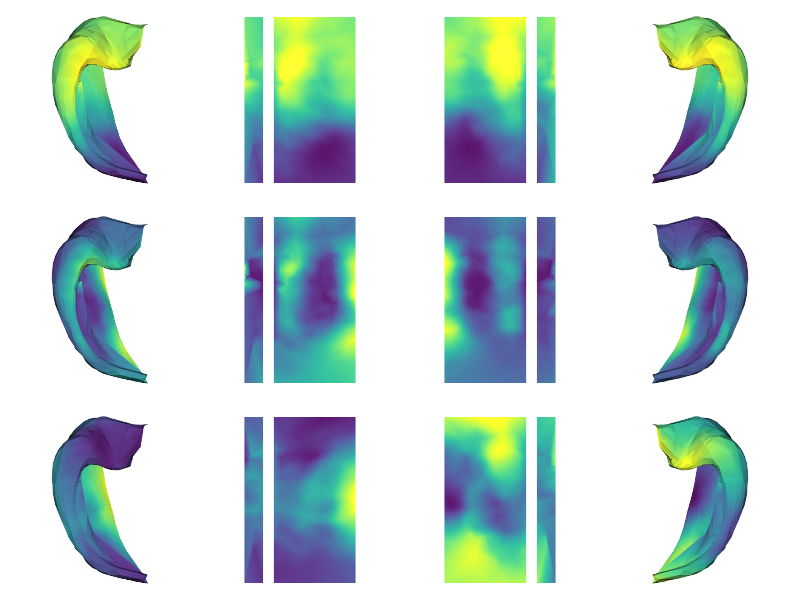

In [9]:
# load and plot reference gradients 
HCPL_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-L.npy')
HCPR_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-R.npy')
plotting.surfplot_canonical_foldunfold(np.stack((HCPL_ref[:,:3],HCPR_ref[:,:3]),axis=1), den='2mm', size=[400,200], embed_nb=True)

In [10]:
#run gradients for all subjects
ngrads = 10
all_grads = np.zeros((483,2,ngrads))
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')

for sub in subs:
    !mkdir -p f'{gradient_dir}/{sub}/{ses}'
    neo_cdata = np.loadtxt(f'{micapipe_dir}/{sub}/{ses}/func/desc-me_task-rest_bold/surf/{sub}_{ses}_surf-fsLR-32k_atlas-schaefer-400_desc-timeseries_clean.txt',delimiter=',')

    for h in range(len(hemi)):
        cdata_hipp = nib.load(f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-hipp_rsfMRI.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-dentate_rsfMRI.func.gii').darrays[0].data
        hipp_neo_data = np.concatenate((cdata_hipp,cdata_dg), axis=0)

        if hemi[h] == 'L':
            neo_cdataL = neo_cdata[:200,:]
            FC = np.corrcoef(hipp_neo_data,neo_cdataL)

            gradientsL = gm.fit(FC[0:483,483:683], reference=HCPL_ref)
            all_grads[:,h,:] = gradientsL.aligned_
            np.savetxt(os.path.join(gradient_dir, f'{sub}/{ses}/{sub}_{ses}_hemi-{hemi[h]}_gradients.txt'), all_grads[:,h,:],delimiter=',')
        else:            
            neo_cdataR = neo_cdata[200:400,:]
            FC = np.corrcoef(hipp_neo_data,neo_cdataR)

            gradientsR = gm.fit(FC[0:483,483:683], reference=HCPR_ref)
            all_grads[:,h,:] = gradientsR.aligned_
            np.savetxt(os.path.join(gradient_dir, f'{sub}/{ses}/{sub}_{ses}_hemi-{hemi[h]}_gradients.txt'), all_grads[:,h,:],delimiter=',')

plotting.surfplot_canonical_foldunfold(all_grads[:,:3], den='2mm', size=[400,200], embed_nb=True)

OSError: /data/mica4/BIDS_MICs_sunset/derivatives/micapipe/sub-HC048/ses-01/func/desc-me_task-rest_bold/surf/sub-HC048_ses-01_surf-fsLR-32k_atlas-schaefer-400_desc-timeseries_clean.txt not found.

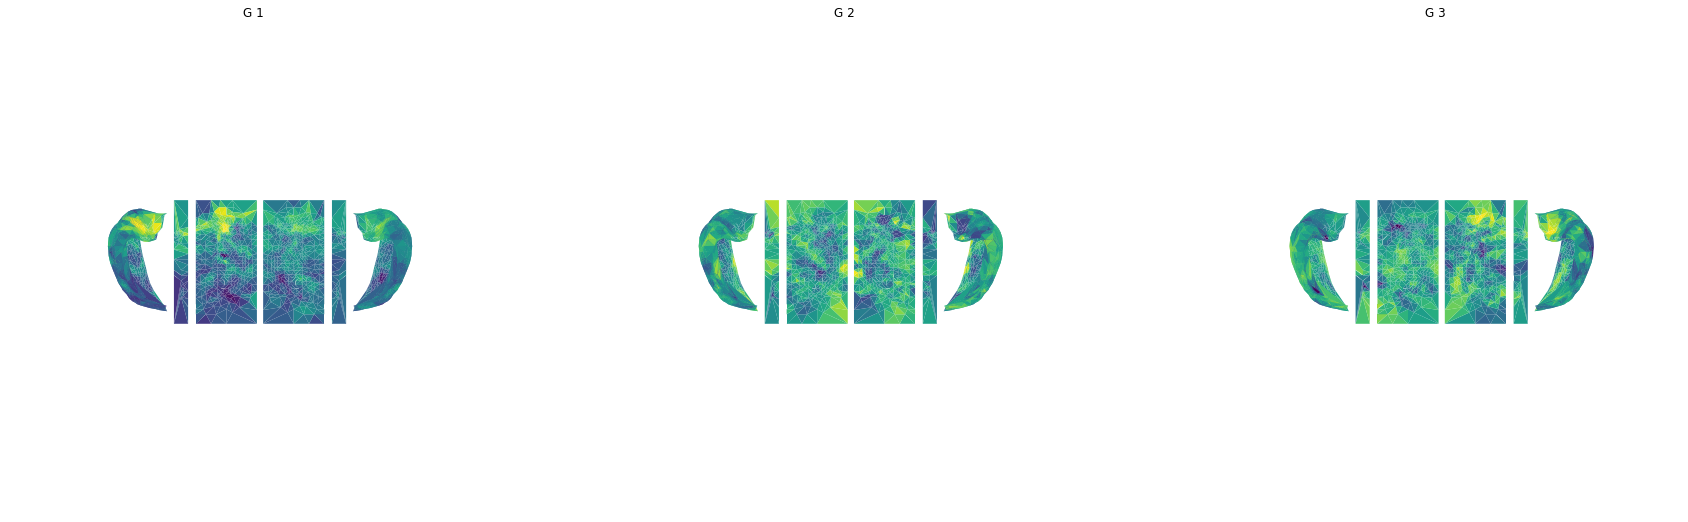

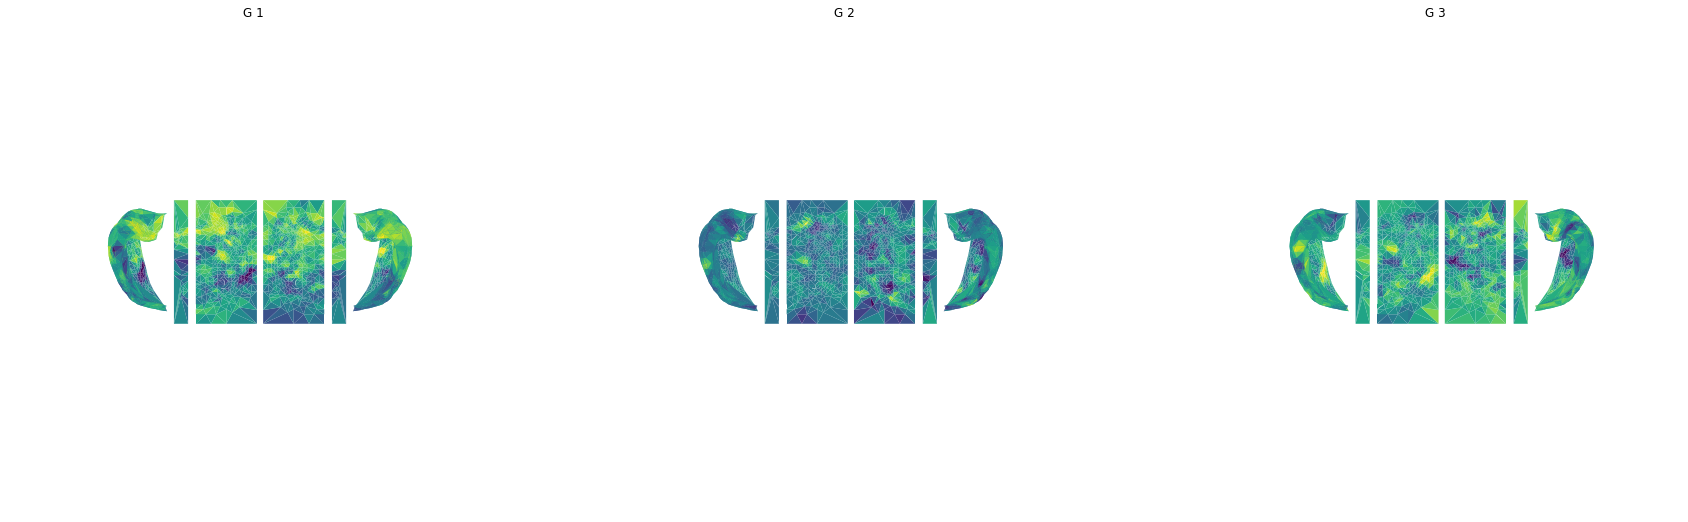

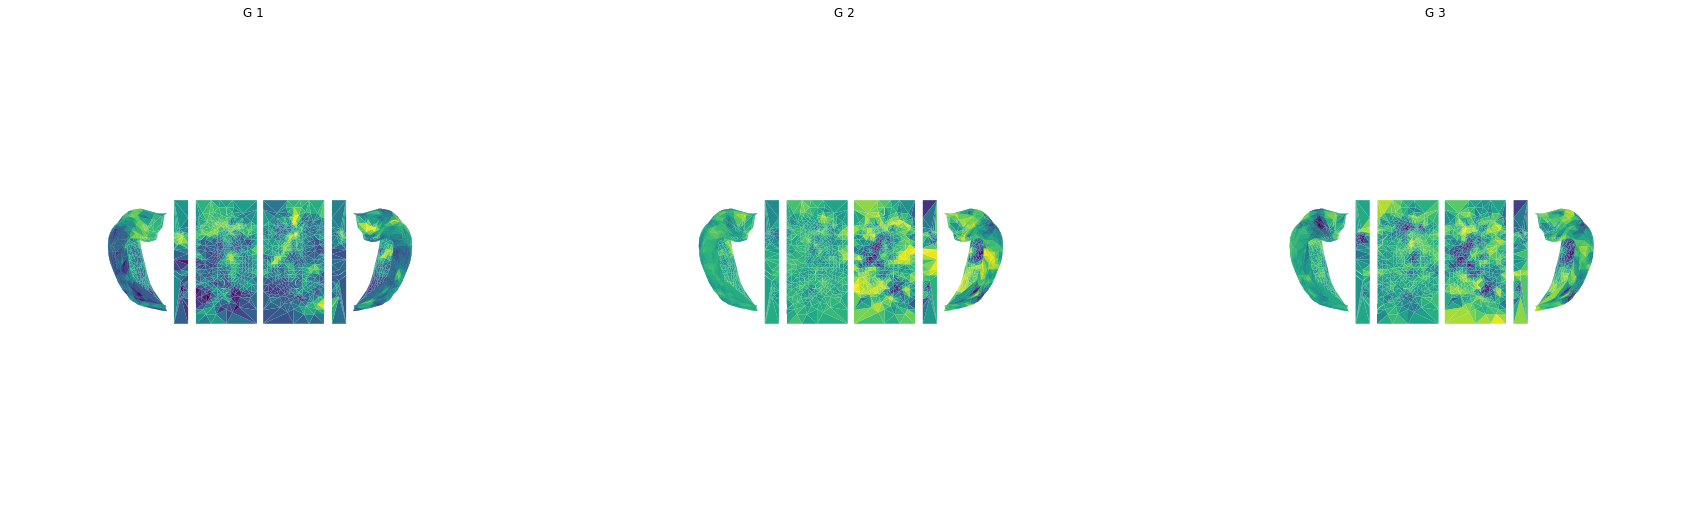

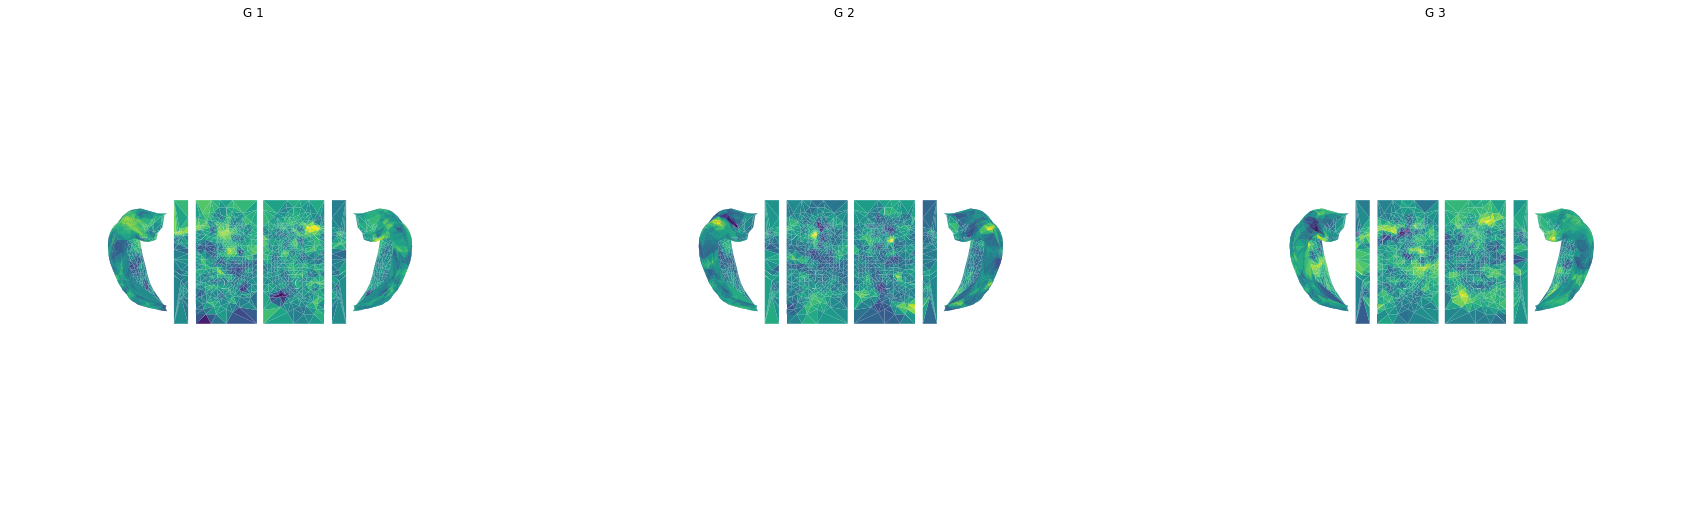

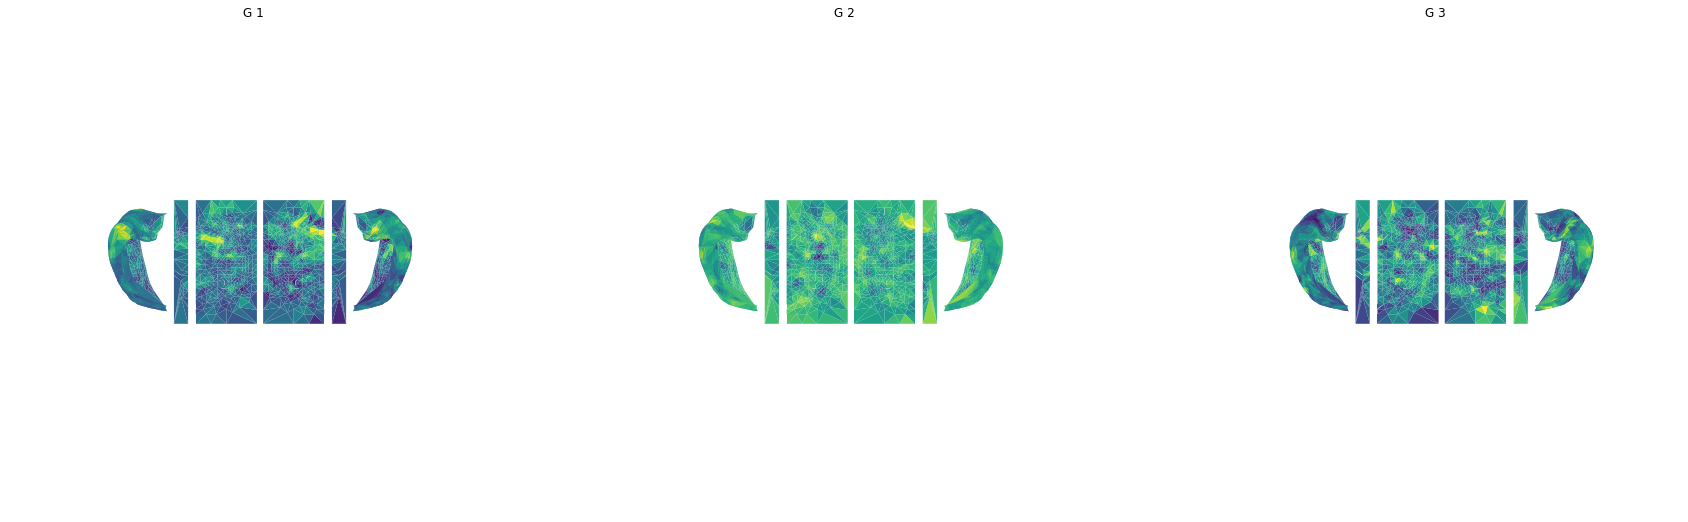

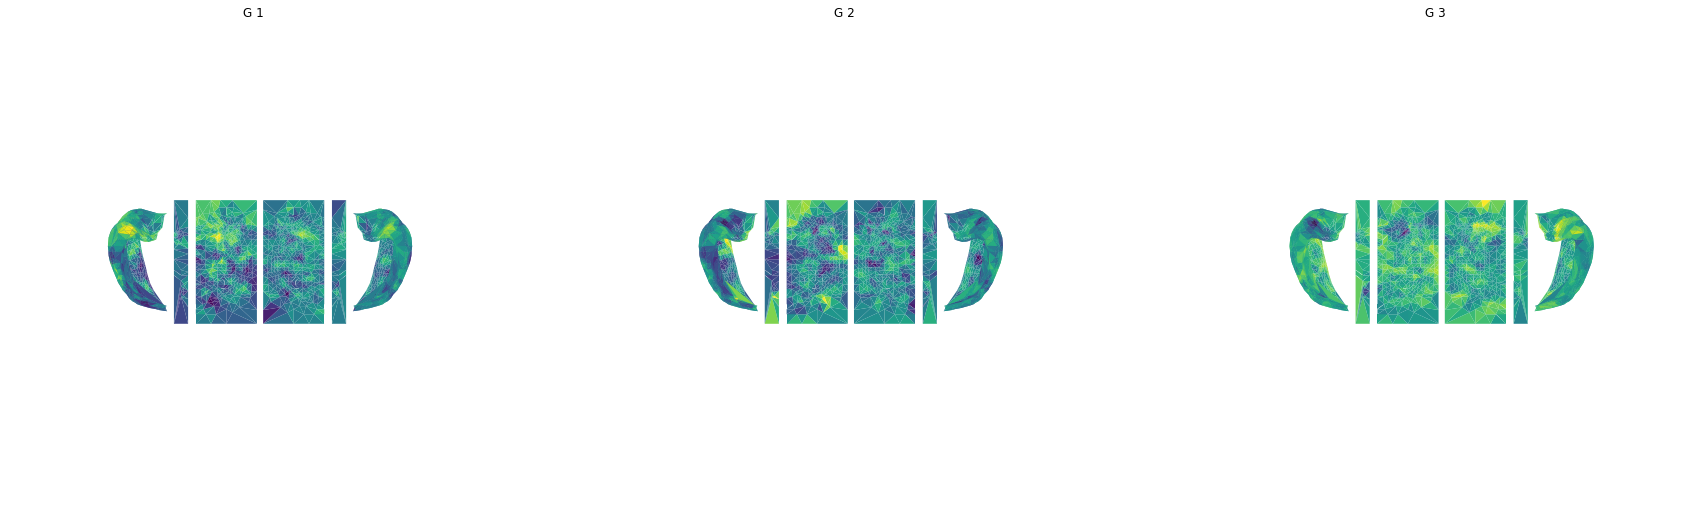

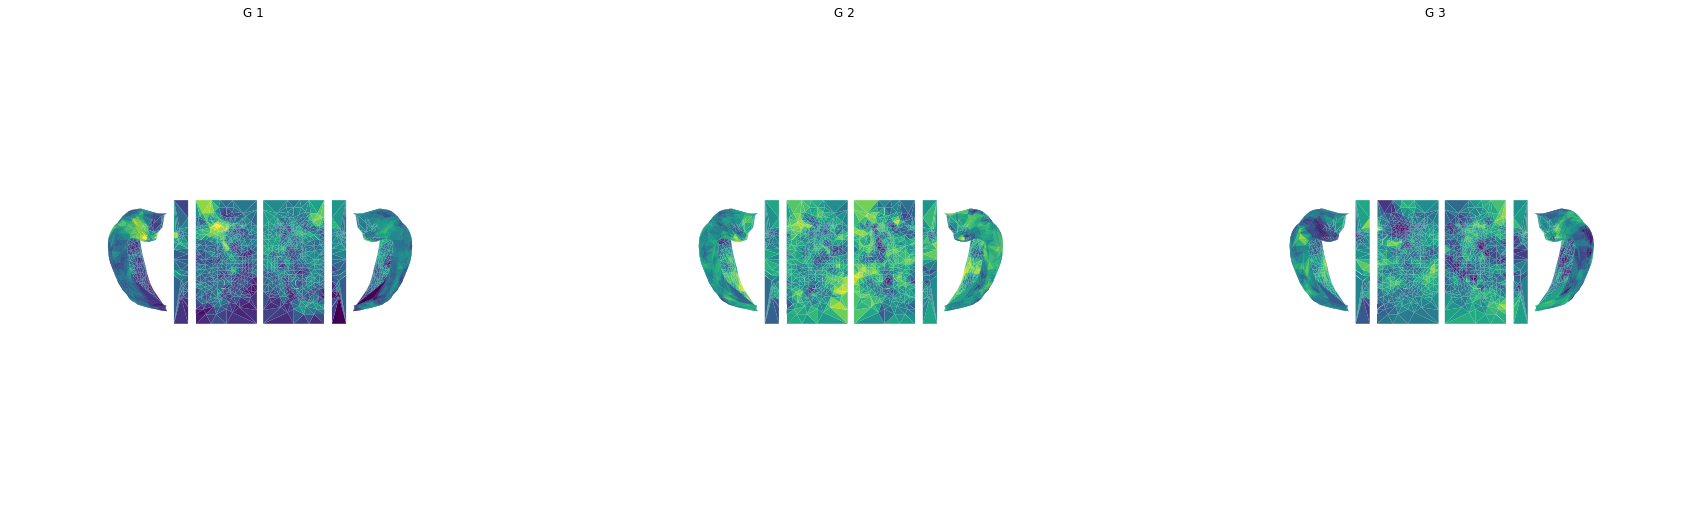

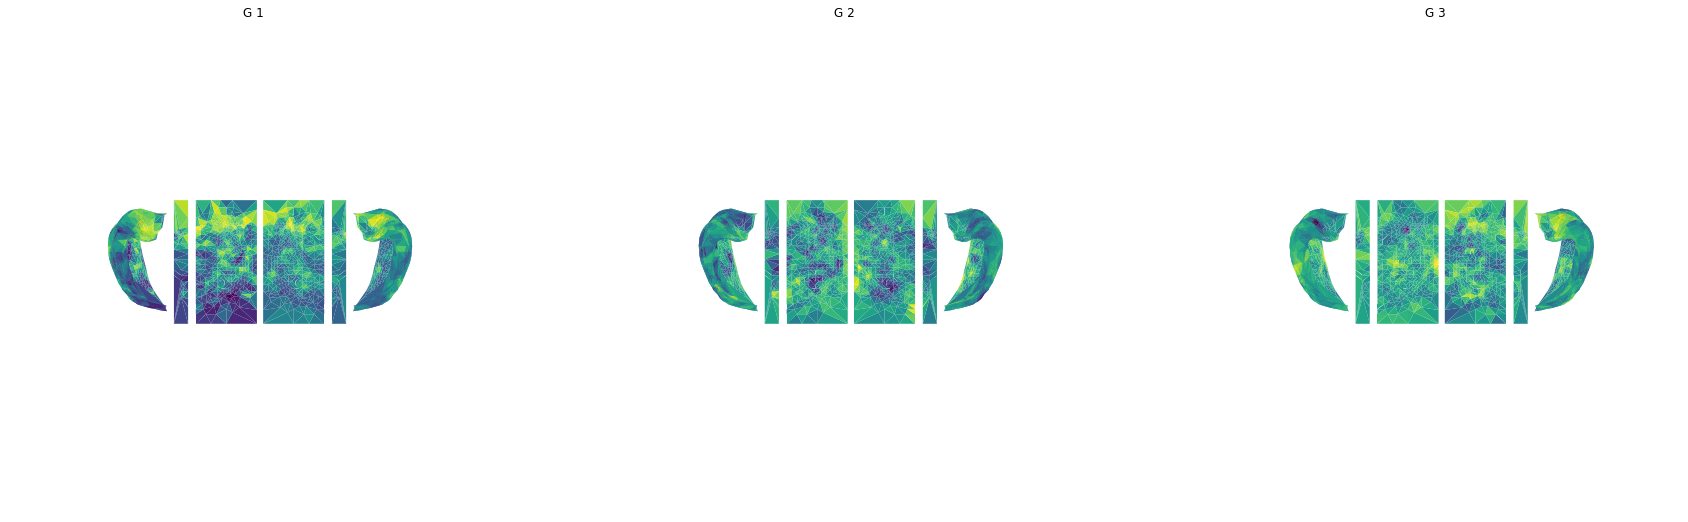

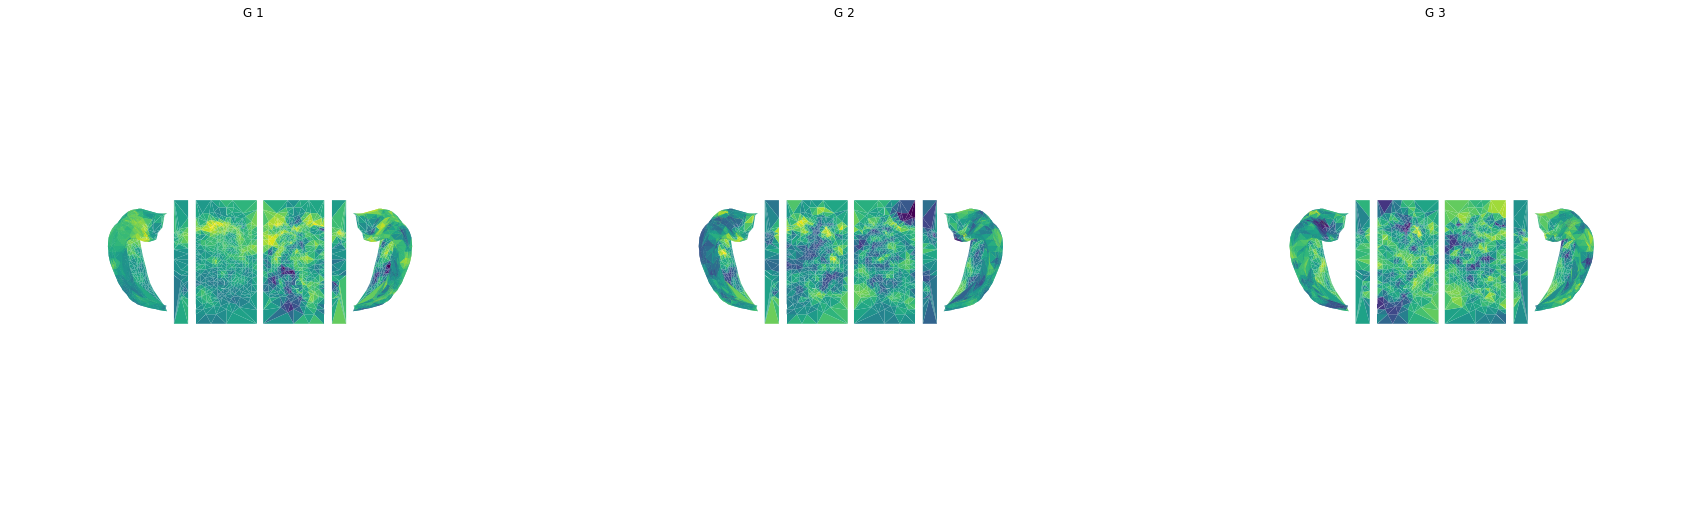

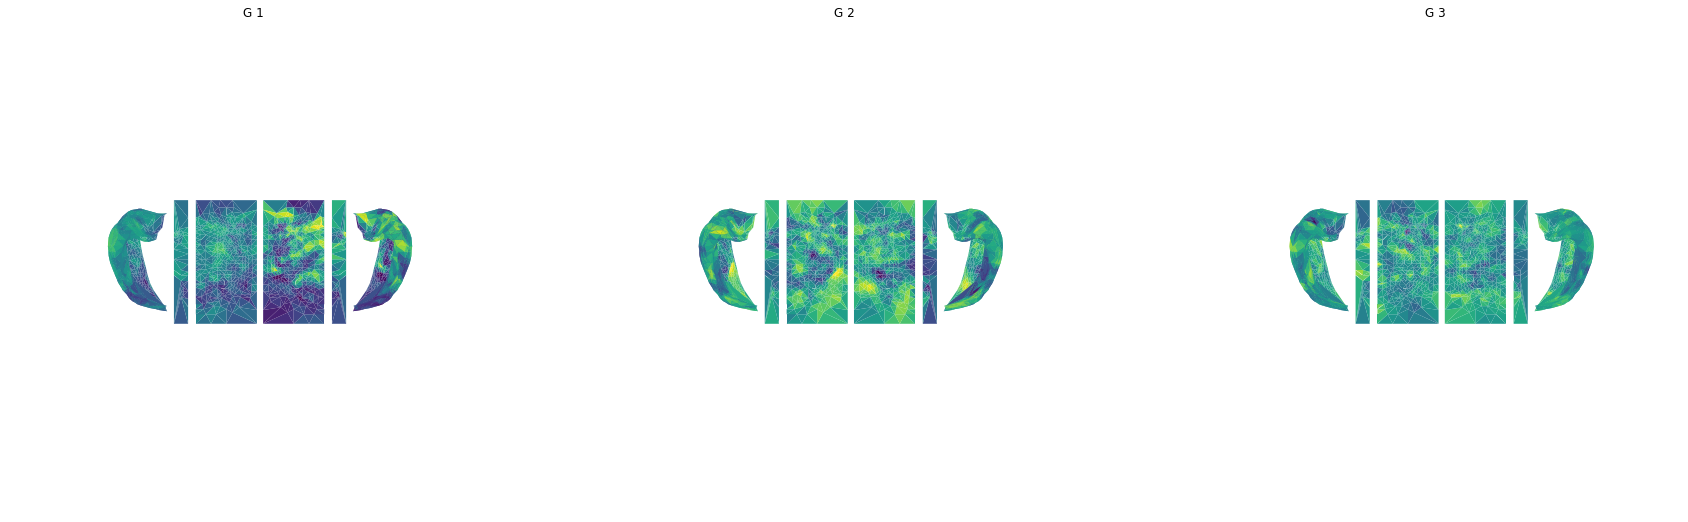

In [17]:
#plot subject specific gradients 
for sub in subs:
    gradientsL = np.loadtxt(f'{gradient_dir}/{sub}/{ses}/{sub}_{ses}_hemi-L_gradients.txt',delimiter=',')
    gradientsR = np.loadtxt(f'{gradient_dir}/{sub}/{ses}/{sub}_{ses}_hemi-R_gradients.txt',delimiter=',')
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,30), subplot_kw={'projection': "3d"})
    for f in range(3):
        plotting.surfplot_canonical_foldunfold(ax[f], np.concatenate((gradientsL[:,f],gradientsR[:,f])), den='2mm')
        ax[f].title.set_text(f'G {str(f+1)}')

In [ ]:
hipp_dat.shape